In [13]:
%matplotlib inline
import talib
import datetime
import numpy as np
import pandas as pd
import matplotlib.finance as finance
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt


def firstday(df):
    return df.sort('date')['date'].head(1).iloc[0].strftime('%Y.%m.%d')

def lastday(df):
    return df.sort('date')['date'].tail(1).iloc[0].strftime('%Y.%m.%d')

'''
Get all available data from yahoo API
Inputs: 
    ticker (str)
    startdate (datetime.date)
    enddate (datetime.date)
Outputs:
    dataframe of daily data from yahoo API in chronological order
'''
def get_data_from_yahoo_api(ticker, startdate=datetime.date(1900, 1, 1), enddate=datetime.date.today()):
    fh = finance.fetch_historical_yahoo(ticker, startdate, enddate)
    r = mlab.csv2rec(fh)
    fh.close()
    df = pd.DataFrame(data = r, columns=['date', 'open', 'high', 'low', 'close', 'volume', 'adj_close']).sort('date')
    df['volume'] = df['volume'].astype(float)
    del df['adj_close']
    print 'Available data: Ticker({ticker}) from {first_day} to {last_day}'.format(ticker=ticker, first_day=firstday(df), last_day=lastday(df))
    return df, r

#Idea/logic from http://stackoverflow.com/questions/25119524/pandas-conditional-rolling-count
def rolling_fill(val):
    rtouse = val
    if val == 0:
        rtouse = rolling_fill.previous
    else:
        rolling_fill.previous = val
    return rtouse

#generate performance indicator result_1, result 14, etc.
def generate_performance_indicator(df):  
    # How to measure
    # First, let's get next day's performance
    df['close_1'] = np.roll(df['close'],-1)
    df['result_1'] = df['close_1'] > df['close']
    df['perf_1'] = (df['close_1']-df['close'])/df['close']

    # I think a better measure would be 14 days' performance
    df['close_14'] = np.roll(df['close'],-13)
    df['result_14'] = df['close_14'] > df['close']
    df['perf_14'] = (df['close_14']-df['close'])/df['close']

    #An even better measure:
    #The Golden Rule of investing is “buy low, sell high.” After analyzing the detail in investment charts, 
    #the best performance would be obtained by “buying” when the index is in a trough, and selling when the 
    #index is at a peak.
    #We manually examined two years of peaks and troughs to come up with an “ideal” in/out scenario.
    #We determined that the peaks and troughs could be recognized to a great degree based on the close price 
    #versus the moving average close price +/-5 days (within a tolerance).
    #Formula: Given “prior tolerance (pt) = 0.2%” and “future tolerance (ft) = 0.5%”
    #“Sell” if ((closing price * (1+pt)) > EMA[-5]) 
    #	AND (closing price * (1+ft) > EMA[+5])
    #“Buy” if ((closing price * (1-pt)) < EMA[-5])
    # 	AND (closing price * (1-ft) < EMA[+5])
    #otherwise, Hold.
    #Using this formula, we could create excellent buy/sell “actual” signals that would maximize up-trends 
    #(by buying in troughs) and minimize downside exposure (by selling at peaks).
    #Our goal would be to match these signals through prior data alone, given that we won’t have the future 
    #5-day moving average.
    ptol = 0.002
    ftol = 0.005
    df['ema5p'] = talib.EMA(df['close'].values, timeperiod=5)
    df['ema5f'] = np.roll(df['ema5p'],-5)
    df['rsell1'] = df['close']*(1+ptol)>df['ema5p']
    df['rsell2'] = df['close']*(1+ftol)>df['ema5f']
    #df['rsell'] = df['rsell1'] & df['rsell2']
    df['rbuy1'] = df['close']*(1-ptol)<df['ema5p']
    df['rbuy2'] = df['close']*(1-ftol)<df['ema5f']
    df['resultt'] = np.where(df['rsell1']&df['rsell2'], -1, np.where(df['rbuy1']&df['rbuy2'], 1, 0))

    del df['ema5p']
    del df['ema5f']
    del df['rsell1']
    del df['rsell2']
    del df['rbuy1']
    del df['rbuy2']
    
    rolling_fill.previous = None #static variable
    df['results'] = df['resultt'].apply(rolling_fill)
    df['results'] = (df['results']+1)/2

    del df['resultt']
    
    return df

#generate all techinical indicator 
def generate_technical_indicators(df, r):
    #Create new fields for various technical indicators directly from talib

    #Bolinger Bands

    #Developed by John Bollinger, Bollinger Bands® are volatility bands placed above and below a moving average. 
    #Volatility is based on the standard deviation, which changes as volatility increases and decreases. 
    #The bands automatically widen when volatility increases and narrow when volatility decreases.

    df['bb_upper'], df['bb_middle'], df['bb_lower'] = talib.BBANDS(df['close'].values, timeperiod=20,
                                                                  nbdevup=2, nbdevdn=2, matype=0)
    df['bb_pct'] = (df['close'] - df['bb_lower'])/(df['bb_upper'] - df['bb_lower'])
    df['bb_bandwidth'] = ( (df['bb_upper'] - df['bb_lower']) / df['bb_middle']) * 100

    #Bollinger BandWidth is best known for identifying The Squeeze. This occurs when volatility falls to a very 
    #low level, as evidenced by the narrowing bands. The upper and lower bands are based on the standard deviation, 
    #which is a measure of volatility. The bands narrow as price flattens or moves within a relatively narrow range. 
    #The theory is that periods of low volatility are followed by periods of high volatility. Relatively narrow 
    #BandWidth (a.k.a. the Squeeze) can foreshadow a significant advance or decline. After a Squeeze, a price surge 
    #and subsequent band break signal the start of a new move. A new advance starts with a Squeeze and subsequent 
    #break above the upper band. A new decline starts with a Squeeze and subsequent break below the lower band.

    df['bb_squeeze'] = df['bb_bandwidth'] < (pd.rolling_mean(df['bb_bandwidth'].values, window=200)*0.4)
    df['bb_signalup'] = df['close'] > df['bb_upper']
    df['bb_signaldn'] = df['close'] < df['bb_lower']
    df['bb_signalt'] = (np.where(df['bb_squeeze'], np.where(df['bb_signalup'], 1, np.where(df['bb_signaldn'], -1, 0)), 0))

    #bb_signal should be 1 (buy) or -1 (sell). A "0" is a "hold" and should be replaced with the last 1 or -1.
    #df['bb_signal'] = np.where(df['bb_signalt']==0,np.roll(df['bb_signalt'],1),df['bb_signalt'])

    rolling_fill.previous = None #static variable
    df['bb_signal'] = df['bb_signalt'].apply(rolling_fill)
    df['bb_signal'] = (df['bb_signal']+1)/2
    df['bb_signal'].fillna(0, inplace=True)

    del df['bb_signalt']
    #df.head(100)
    #Moving averages smooth the price data to form a trend following indicator. They do not predict price 
    #direction, but rather define the current direction with a lag. Moving averages lag because they are based 
    #on past prices.

    #Exponential Moving Average
    #Exponential moving averages have less lag and are therefore more sensitive to recent prices - 
    #and recent price changes. Exponential moving averages will turn before simple moving averages.

    df['ema50'] = talib.EMA(df['close'].values, timeperiod=50)
    df['ema150'] = talib.EMA(df['close'].values, timeperiod=150)
    df['ema200'] = talib.EMA(df['close'].values, timeperiod=200)

    #Trend Identification
    #The direction of the moving average conveys important information about prices. 
    #A rising moving average shows that prices are generally increasing. 
    #A falling moving average indicates that prices, on average, are falling.

    #Price Crossovers
    #Moving averages can be used to generate signals with simple price crossovers. 
    #A bullish signal is generated when prices move above the moving average. 
    #A bearish signal is generated when prices move below the moving average.

    df['ema_signal1'] = 1*(df['close'] > df['ema150'])

    #Double Crossovers
    #Two moving averages can be used together to generate crossover signals. 
    #In Technical Analysis of the Financial Markets, John Murphy calls this the “double crossover method”. 
    #Double crossovers involve one relatively short moving average and one relatively long moving average. 
    #As with all moving averages, the general length of the moving average defines the timeframe for the system. 
    #A system using a 50-day SMA and 200-day SMA would be deemed medium-term, perhaps even long-term.
    #A bullish crossover occurs when the shorter moving average crosses above the longer moving average. 
    #This is also known as a golden cross. A bearish crossover occurs when the shorter moving average crosses 
    #below the longer moving average. This is known as a dead cross.

    df['ema_signal2'] = 1*(df['ema50'] > df['ema200'])


    #Double Exponential Moving Average
    #df['dema50'] = talib.DEMA(df['close'].values, timeperiod=50)
    #df['dema100'] = talib.DEMA(df['close'].values, timeperiod=100)
    #df['dema200'] = talib.DEMA(df['close'].values, timeperiod=200)

    #Weighted Moving Average
    #df['wma50'] = talib.WMA(df['close'].values, timeperiod=50)
    #df['wma100'] = talib.WMA(df['close'].values, timeperiod=100)
    #df['wma200'] = talib.WMA(df['close'].values, timeperiod=200)

    #Simple Moving Average
    #df['sma50'] = talib.SMA(df['close'].values, timeperiod=50)
    #df['sma100'] = talib.SMA(df['close'].values, timeperiod=100)
    #df['sma200'] = talib.SMA(df['close'].values, timeperiod=200)

    #Moving Average Shell
    #df['ma50'] = talib.MA(df['close'].values, timeperiod=50, matype=0)
    #df['ma100'] = talib.MA(df['close'].values, timeperiod=100, matype=0)
    #df['ma200'] = talib.MA(df['close'].values, timeperiod=200, matype=0)

    #Kaufman Adaptive Moving Average
    #Developed by Perry Kaufman, Kaufman's Adaptive Moving Average (KAMA) is a moving average designed 
    #to account for market noise or volatility. KAMA will closely follow prices when the price swings are 
    #relatively small and the noise is low. KAMA will adjust when the price swings widen and follow prices 
    #from a greater distance. This trend-following indicator can be used to identify the overall trend, 
    #time turning points and filter price movements.

    #Chartists can use KAMA like any other trend following indicator, such as a moving average. 
    #Chartists can look for price crosses, directional changes and filtered signals.

    df['kama50'] = talib.KAMA(df['close'].values, timeperiod=50)
    df['kama150'] = talib.KAMA(df['close'].values, timeperiod=150)
    df['kama200'] = talib.KAMA(df['close'].values, timeperiod=200)

    df['kama_signal1'] = 1*(df['close'] > df['kama150'])
    df['kama_signal2'] = 1*(df['kama50'] > df['kama200'])

    #Parabolic SAR
    #Developed by Welles Wilder, the Parabolic SAR refers to a price-and-time-based trading system. 
    #Wilder called this the “Parabolic Time/Price System.” SAR stands for “stop and reverse,” which is the 
    #actual indicator used in the system. SAR trails price as the trend extends over time. The indicator is 
    #below prices when prices are rising and above prices when prices are falling. In this regard, the indicator 
    #stops and reverses when the price trend reverses and breaks above or below the indicator.

    df['sar'] = talib.SAR(df['high'].values, df['low'].values, acceleration=0.02, maximum=0.2)
    df['sar_signal'] = 1*(df['close'] > df['sar'])

    #Average Directional Movement Index
    #The Average Directional Index (ADX), Minus Directional Indicator (-DI) and Plus Directional Indicator (+DI) 
    #represent a group of directional movement indicators that form a trading system developed by Welles Wilder. 
    #Wilder designed ADX with commodities and daily prices in mind, but these indicators can also be applied to stocks. 
    #The Average Directional Index (ADX) measures trend strength without regard to trend direction. The other two 
    #indicators, Plus Directional Indicator (+DI) and Minus Directional Indicator (-DI), complement ADX by defining 
    #trend direction. Used together, chartists can determine both the direction and strength of the trend.

    df['adx'] = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)
    df['plus_di'] = talib.PLUS_DI(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)
    df['minus_di'] = talib.MINUS_DI(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)

    df['adx_trend'] = df['adx'] > 22
    df['adx_direction'] = df['plus_di'] > df['minus_di']
    df['adx_signalt'] = np.where(df['adx_trend'], np.where(df['adx_direction'],1,-1), 0)

    rolling_fill.previous = None #static variable
    df['adx_signal'] = df['adx_signalt'].apply(rolling_fill)
    df['adx_signal'] = (df['adx_signal']+1)/2

    del df['adx_signalt']

    #Aroon
    #Developed by Tushar Chande in 1995, Aroon is an indicator system that determines whether a stock is 
    #trending or not and how strong the trend is. The Aroon indicators measure the number of periods since 
    #price recorded an x-day high or low. There are two separate indicators: Aroon-Up and Aroon-Down. 
    #A 25-day Aroon-Up measures the number of days since a 25-day high. A 25-day Aroon-Down measures the 
    #number of days since a 25-day low.

    #df['aroon_dn'], df['aroon_up'] = talib.AROON(df['high'].values, df['low'].values, timeperiod=25)

    #Aroon Oscillator
    #The Aroon Oscillator is the difference between Aroon-Up and Aroon-Down. These two indicators are usually 
    #plotted together for easy comparison, but chartists can also view the difference of these two indicators 
    #with the Aroon Oscillator. This indicator fluctuates between -100 and +100 with zero as the middle line. 
    #A upward trend bias is present when the oscillator is positive, while a downward trend bias exists when the 
    #oscillator is negative.

    df['aroon_osc'] = talib.AROONOSC(df['high'].values, df['low'].values, timeperiod=25)

    df['aroon_signal'] = 1*(df['aroon_osc'] >= 0)

    #Commodity Channel Index
    #Developed by Donald Lambert and featured in Commodities magazine in 1980, the Commodity Channel Index (CCI) 
    #is a versatile indicator that can be used to identify a new trend or warn of extreme conditions. 
    #Lambert originally developed CCI to identify cyclical turns in commodities, but the indicator can successfully 
    #applied to indices, ETFs, stocks and other securities. In general, CCI measures the current price level relative 
    #to an average price level over a given period of time. CCI is relatively high when prices are far above their 
    #average. CCI is relatively low when prices are far below their average. In this manner, CCI can be used to 
    #identify overbought and oversold levels.

    df['cci'] = talib.CCI(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)

    #The definition of overbought or oversold varies for the Commodity Channel Index (CCI). 
    #±100 may work in a trading range, but more extreme levels are needed for other situations. 
    #±200 is a much harder level to reach and more representative of a true extreme.

    df['cci_signalt'] = np.where(df['cci'] < -200, 1, np.where(df['cci'] > 200, -1, 0))

    rolling_fill.previous = None #static variable
    df['cci_signal'] = df['cci_signalt'].apply(rolling_fill)
    df['cci_signal'] = (df['cci_signal']+1)/2

    del df['cci_signalt']

    #Moving Average Convergence/Divergence
    #Developed by Gerald Appel in the late seventies, the Moving Average Convergence/Divergence oscillator 
    #(MACD) is one of the simplest and most effective momentum indicators available. The MACD turns two 
    #trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving 
    #average from the shorter moving average. As a result, the MACD offers the best of both worlds: trend 
    #following and momentum. The MACD fluctuates above and below the zero line as the moving averages converge, 
    #cross and diverge. Traders can look for signal line crossovers, centerline crossovers and divergences to 
    #generate signals. 

    #Interpretation
    #As its name implies, the MACD is all about the convergence and divergence of the two moving averages. 
    #Convergence occurs when the moving averages move towards each other. 
    #Divergence occurs when the moving averages move away from each other. 
    #The shorter moving average (12-day) is faster and responsible for most MACD movements. 
    #The longer moving average (26-day) is slower and less reactive to price changes in the underlying security.

    #The MACD Line oscillates above and below the zero line, which is also known as the centerline. 
    #These crossovers signal that the 12-day EMA has crossed the 26-day EMA. 
    #The direction, of course, depends on the direction of the moving average cross. 
    #Positive MACD indicates that the 12-day EMA is above the 26-day EMA. 
    #Positive values increase as the shorter EMA diverges further from the longer EMA. 
    #This means upside momentum is increasing. 
    #Negative MACD values indicates that the 12-day EMA is below the 26-day EMA. 
    #Negative values increase as the shorter EMA diverges further below the longer EMA. 
    #This means downside momentum is increasing.

    #Signal line crossovers are the most common MACD signals. 
    #The signal line is a 9-day EMA of the MACD Line. As a moving average of the indicator, 
    #it trails the MACD and makes it easier to spot MACD turns. A bullish crossover occurs 
    #when the MACD turns up and crosses above the signal line. A bearish crossover occurs when 
    #the MACD turns down and crosses below the signal line. Crossovers can last a few days or 
    #a few weeks, it all depends on the strength of the move.

    df['macd'], df['macd_sigline'], df['macd_hist'] = talib.MACD(df['close'].values,
                                                               fastperiod=12, slowperiod=26, signalperiod=9)
    df['macd_signal'] = 1*(df['macd_hist'] > 0)

    #Percentage Price Oscillator
    #The Percentage Price Oscillator (PPO) is a momentum oscillator that measures the difference between two 
    #moving averages as a percentage of the larger moving average. As with its cousin, MACD, the Percentage 
    #Price Oscillator is shown with a signal line, a histogram and a centerline. Signals are generated with 
    #signal line crossovers, centerline crossovers and divergences. Because these signals are no different 
    #than those associated with MACD, this article will focus on a few differences between the two. 
    #First, PPO readings are not subject to the price level of the security. Second, PPO readings for different 
    #securities can be compared, even when there are large differences in the price.

    df['ppo'] = talib.PPO(df['close'].values, fastperiod=12, slowperiod=26, matype=0)

    df['ppo_signal'] = 1*(df['ppo'] > 0)

    #Money Flow Index
    #The Money Flow Index (MFI) is an oscillator that uses both price and volume to measure buying and selling 
    #pressure. Created by Gene Quong and Avrum Soudack, MFI is also known as volume-weighted RSI. MFI starts 
    #with the typical price for each period. Money flow is positive when the typical price rises (buying pressure) 
    #and negative when the typical price declines (selling pressure). 

    #Overbought and oversold levels can be used to identify unsustainable price extremes. 
    #Typically, MFI above 80 is considered overbought and MFI below 20 is considered oversold. 
    #Strong trends can present a problem for these classic overbought and oversold levels. 
    #MFI can become overbought (>80) and prices can simply continue higher when the uptrend is strong. 
    #Conversely, MFI can become oversold (<20) and prices can simply continue lower when the downtrend is strong.

    df['mfi'] = talib.MFI(df['high'].values, df['low'].values, df['close'].values, df['volume'].values, timeperiod=14)

    df['mfi_signalt'] = np.where(df['mfi'] < 20, 1, np.where(df['mfi'] > 80, -1, 0))

    rolling_fill.previous = None #static variable
    df['mfi_signal'] = df['mfi_signalt'].apply(rolling_fill)
    df['mfi_signal'] = (df['mfi_signal']+1)/2

    del df['mfi_signalt']

    #Rate of change percentage
    #The Rate-of-Change (ROC) indicator, which is also referred to as simply Momentum, is a pure momentum 
    #oscillator that measures the percent change in price from one period to the next. The ROC calculation 
    #compares the current price with the price “n” periods ago. The plot forms an oscillator that fluctuates 
    #above and below the zero line as the Rate-of-Change moves from positive to negative.

    df['roc'] = 100*talib.ROCP(df['close'].values, timeperiod=10)

    #The 20-day Rate-of-Change indicator sets overbought at +10% and oversold at -10%.

    df['roc_signalt'] = np.where(df['roc'] < -10, 1, np.where(df['roc'] > 10, -1, 0))

    rolling_fill.previous = None #static variable
    df['roc_signal'] = df['roc_signalt'].apply(rolling_fill)
    df['roc_signal'] = (df['roc_signal']+1)/2

    del df['roc_signalt']

    #Relative Strength Index
    #Developed J. Welles Wilder, the Relative Strength Index (RSI) is a momentum oscillator that measures the 
    #speed and change of price movements. RSI oscillates between zero and 100. Traditionally, and according to 
    #Wilder, RSI is considered overbought when above 70 and oversold when below 30. Signals can also be generated 
    #by looking for divergences, failure swings and centerline crossovers. RSI can also be used to identify the 
    #general trend.

    df['rsi'] = talib.RSI(df['close'].values, timeperiod=14)

    df['rsi_signalt'] = np.where(df['rsi'] < 30, 1, np.where(df['rsi'] > 70, -1, 0))

    rolling_fill.previous = None #static variable
    df['rsi_signal'] = df['rsi_signalt'].apply(rolling_fill)
    df['rsi_signal'] = (df['rsi_signal']+1)/2

    del df['rsi_signalt']

    #Ultimate Oscillator
    #Developed by Larry Williams in 1976 and featured in Stocks & Commodities Magazine in 1985, the Ultimate 
    #Oscillator is a momentum oscillator designed to capture momentum across three different time frames. 
    #The multiple time frame objective seeks to avoid the pitfalls of other oscillators. Many momentum oscillators 
    #surge at the beginning of a strong advance and then form bearish divergence as the advance continues. 
    #This is because they are stuck with one time frame. The Ultimate Oscillator attempts to correct this fault 
    #by incorporating longer time frames into the basic formula. Williams identified a buy signal a based on a 
    #bullish divergence and a sell signal based on a bearish divergence.

    df['ult_osc'] = talib.ULTOSC(df['high'].values, df['low'].values, df['close'].values, 
                                timeperiod1=7, timeperiod2=14, timeperiod3=28)

    #Simplified, the ultimate oscillator is considered overbought when above 70 and oversold when below 30.

    df['ult_signalt'] = np.where(df['ult_osc'] < 30, 1, np.where(df['ult_osc'] > 70, -1, 0))

    rolling_fill.previous = None #static variable
    df['ult_signal'] = df['ult_signalt'].apply(rolling_fill)
    df['ult_signal'] = (df['ult_signal']+1)/2

    del df['ult_signalt']

    #Williams' %R
    #Developed by Larry Williams, Williams %R is a momentum indicator that is the inverse of the Fast 
    #Stochastic Oscillator. Also referred to as %R, Williams %R reflects the level of the close relative 
    #to the highest high for the look-back period. In contrast, the Stochastic Oscillator reflects the level 
    #of the close relative to the lowest low. %R corrects for the inversion by multiplying the raw value by -100. 
    #As a result, the Fast Stochastic Oscillator and Williams %R produce the exact same lines, only the scaling 
    #is different. Williams %R oscillates from 0 to -100.

    df['willr'] = talib.WILLR(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)

    #Readings from 0 to -20 are considered overbought. Readings from -80 to -100 are considered oversold.

    df['wr_signalt'] = np.where(df['willr'] < -80, 1, np.where(df['willr'] > -20, -1, 0))

    rolling_fill.previous = None #static variable
    df['wr_signal'] = df['wr_signalt'].apply(rolling_fill)
    df['wr_signal'] = (df['wr_signal']+1)/2

    del df['wr_signalt']

    #Chaikin A/D Line
    #Developed by Marc Chaikin, the Accumulation Distribution Line is a volume-based indicator designed to 
    #measure the cumulative flow of money into and out of a security. Chaikin originally referred to the indicator 
    #as the Cumulative Money Flow Line. As with cumulative indicators, the Accumulation Distribution Line is a 
    #running total of each period's Money Flow Volume. First, a multiplier is calculated based on the relationship 
    #of the close to the high-low range. Second, the Money Flow Multiplier is multiplied by the period's volume to 
    #come up with a Money Flow Volume. A running total of the Money Flow Volume forms the Accumulation Distribution 
    #Line. Chartists can use this indicator to affirm a security's underlying trend or anticipate reversals when 
    #the indicator diverges from the security price.

    #df['ad'] = talib.AD(df['high'].values, df['low'].values, df['close'].values, df['volume'].values)

    #Chaikin A/D Oscillator
    #Trend confirmation is a pretty straight-forward concept. An uptrend in the Accumulation Distribution Line 
    #reinforces an uptrend on the price chart and vice versa.

    df['ad_osc'] = talib.ADOSC(df['high'].values, df['low'].values, df['close'].values, df['volume'].values,
                              fastperiod=3, slowperiod=10)

    df['ad_signal'] = 1*(df['ad_osc'] > 0)
    #On Balance Volume
    #On Balance Volume (OBV) measures buying and selling pressure as a cumulative indicator that adds volume 
    #on up days and subtracts volume on down days. OBV was developed by Joe Granville and introduced in his 1963 
    #book, Granville's New Key to Stock Market Profits. It was one of the first indicators to measure positive 
    #and negative volume flow. Chartists can look for divergences between OBV and price to predict price movements 
    #or use OBV to confirm price trends.

    #df['obv'] = talib.OBV(df['close'].values, df['volume'].values)

    #Stochastic
    #Developed by George C. Lane in the late 1950s, the Stochastic Oscillator is a momentum indicator that shows 
    #the location of the close relative to the high-low range over a set number of periods. According to an interview 
    #with Lane, the Stochastic Oscillator “doesn't follow price, it doesn't follow volume or anything like that. 
    #It follows the speed or the momentum of price. As a rule, the momentum changes direction before price.” As such, 
    #bullish and bearish divergences in the Stochastic Oscillator can be used to foreshadow reversals. This was the 
    #first, and most important, signal that Lane identified. Lane also used this oscillator to identify bull and bear 
    #set-ups to anticipate a future reversal. Because the Stochastic Oscillator is range bound, is also useful for 
    #identifying overbought and oversold levels.

    df['stoch_slowk'], df['stoch_slowd'] = talib.STOCH(df['high'].values, df['low'].values, df['close'].values, 
                                                       fastk_period=5,
                                                        slowk_period=3,
                                                        slowk_matype=0,
                                                        slowd_period=3,
                                                        slowd_matype=0)

    #Traditional settings use 80 as the overbought threshold and 20 as the oversold threshold.

    df['sslow_signalt'] = np.where(df['stoch_slowk'] < 20, 1, np.where(df['stoch_slowk'] > 80, -1, 0))

    rolling_fill.previous = None #static variable
    df['sslow_signal'] = df['sslow_signalt'].apply(rolling_fill)
    df['sslow_signal'] = (df['sslow_signal']+1)/2

    del df['sslow_signalt']
    #Stochastic Relative Strength Index
    #Developed by Tushar Chande and Stanley Kroll, StochRSI is an oscillator that measures the level of RSI 
    #relative to its high-low range over a set time period. StochRSI applies the Stochastics formula to RSI values, 
    #instead of price values. This makes it an indicator of an indicator. The result is an oscillator that 
    #fluctuates between 0 and 1.

    df['stoch_fastk'], df['stoch_fastd'] = talib.STOCHRSI(df['close'].values, timeperiod=14,
                                                          fastk_period=5, fastd_period=3, fastd_matype=0)

    #In their 1994 book, The New Technical Trader, Chande and Kroll explain that RSI can oscillate between 
    #80 and 20 for extended periods without reaching extreme levels. Notice that 80 and 20 are used for overbought 
    #and oversold instead of the more traditional 70 and 30. Traders looking to enter a stock based on an overbought 
    #or oversold reading in RSI might find themselves continuously on the sidelines. Chande and Kroll developed 
    #StochRSI to increase sensitivity and generate more overbought/oversold signals.

    df['srsi_signalt'] = np.where(df['stoch_fastk'] < 20, 1, np.where(df['stoch_fastk'] > 80, -1, 0))

    rolling_fill.previous = None #static variable
    df['srsi_signal'] = df['srsi_signalt'].apply(rolling_fill)
    df['srsi_signal'] = (df['srsi_signal']+1)/2

    del df['srsi_signalt']
    #1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
    #TRIX is a momentum oscillator that displays the percent rate of change of a triple exponentially smoothed 
    #moving average. It was developed in the early 1980's by Jack Hutson, an editor for Technical Analysis of 
    #Stocks and Commodities magazine. With its triple smoothing, TRIX is designed to filter insignificant price 
    #movements. Chartists can use TRIX to generate signals similar to MACD. A signal line can be applied to look 
    #for signal line crossovers. A directional bias can be determined with the absolute level. Bullish and bearish 
    #divergences can be used to anticipate reversals.

    df['trix'] = talib.TRIX(df['close'].values, timeperiod=30)

    df['trix_signal'] = 1*(df['trix'] > 0)
    #Derive fields for Support and Resistance

    tperiod = 30
    lotrade = talib.MIN(df['low'].values, timeperiod=tperiod)
    hitrade = talib.MAX(df['high'].values, timeperiod=tperiod)
    df['sr_pivotpts'] = (df['high'].values + df['low'].values + df['close'].values)/3
    df['sr_res1'] = 2*df['sr_pivotpts'].values - lotrade
    df['sr_sup1'] = 2*df['sr_pivotpts'].values - hitrade
    df['sr_res2'] = df['sr_pivotpts'].values + (hitrade - lotrade)
    df['sr_sup2'] = df['sr_pivotpts'].values - (hitrade - lotrade)
    df['sr_res3'] = hitrade + 2*(df['sr_pivotpts'].values - lotrade)
    df['sr_sup3'] = lotrade - 2*(hitrade - df['sr_pivotpts'].values)

    #Derive Custom Volatility Signal

    rangetol1, rangetol2 = 0.005, 0.005
    dv = pd.DataFrame(data = r, columns=['date', 'open', 'high', 'low', 'close', 'volume', 'adj_close'])
    dv['range'] = dv['high'].values - dv['low'].values
    dv['rangepct'] = dv['range'].values/dv['low'].values
    dv['prior'] = talib.SUM(dv['close'].values, timeperiod=2) - dv['close'].values
    dv['perf'] = (dv['close'].values - dv['prior'].values) / dv['prior'].values
    dv['r180'] = pd.rolling_mean(dv['rangepct'].values, window=180)
    #dv['vtest1'] = (dv['perf'].values>0 & (dv['rangepct'].values > (dv['r180'].values + rangetol1)))
    dv['vtest1a'] = dv['perf'].values > 0
    dv['vtest1b'] = (dv['rangepct'].values > (dv['r180'].values + rangetol1))
    dv['vtest1'] = dv['vtest1a'] & dv['vtest1b']
    #dv['vtest2'] = (dv['perf'].values<0 & (dv['rangepct'].values > (dv['r180'].values + rangetol2)))
    dv['vtest2a'] = dv['perf'].values < 0
    dv['vtest2b'] = (dv['rangepct'].values > (dv['r180'].values + rangetol2))
    dv['vtest2'] = dv['vtest2a'] & dv['vtest2b']
    dv['vc'] = dv['vtest1'] | dv['vtest2']
    dv['atest1'] = (pd.rolling_sum(dv['vc'], window=3) - dv['vc']) <= 1
    dv['atest2'] = pd.rolling_sum(dv['vc'], window=5) == 0.
    dv['atest3'] = pd.rolling_sum(dv['vc'], window=15) <= 1.
    dv['atest23'] = (dv['atest2'] | dv['atest3'])
    dv['in_or_out'] = dv['atest1'] & dv['atest23']
    dv['in_or_out_p'] = (pd.rolling_sum(dv['in_or_out'], window=2) - dv['in_or_out']) == 1
    dv['in_or_out_e'] = dv['in_or_out'] == dv['in_or_out_p']
    dv['cv_signal'] = dv['in_or_out'] & dv['in_or_out_e']

    df['cv_signal'] = 1*dv['cv_signal']
    return df


#return the dataset for further analysis and save a copy as csv file
def generate_ticker_data(ticker, startdate, enddate):
    df, r = get_data_from_yahoo_api(ticker)
    df = generate_performance_indicator(df)
    df = generate_technical_indicators(df, r)
    df = df.dropna()
    print 'Usable data: Ticker({ticker}) from {first_day} to {last_day} '.format(ticker=ticker, first_day=firstday(df), last_day=lastday(df))
    
    df = df[df.date>=startdate]
    df = df[df.date<=enddate]
    print 'Returned data: Ticker({ticker}) from {first_day} to {last_day} '.format(ticker=ticker, first_day=firstday(df), last_day=lastday(df))
    
    tofile = 'data/{0}_from_{1}_{2}.csv'.format(ticker, firstday(df), lastday(df))
    print "Save path: " + tofile
    df.to_csv(tofile, index=False)    
    
    return df.reset_index(drop=True)

In [14]:
ticker = 'IYZ'
df = generate_ticker_data(ticker=ticker, startdate=datetime.date(2001, 1, 1), enddate=datetime.date.today())
df.head()

Available data: Ticker(IYZ) from 2000.05.26 to 2015.11.27
Usable data: Ticker(IYZ) from 2001.03.14 to 2015.11.27 
Returned data: Ticker(IYZ) from 2001.03.14 to 2015.11.27 
Save path: data/IYZ_from_2001.03.14_2015.11.27.csv


,date,open,high,low,close,volume,close_1,result_1,perf_1,close_14,...,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal
0,2001-03-14,37.450001,37.950001,36.320000,36.840000,8800,37.599998,True,0.020630,36.400002,...,-0.176945,0,37.036667,37.753334,27.673332,47.116669,26.956665,47.833336,17.593330,0
1,2001-03-15,37.450001,37.919998,37.400002,37.599998,16200,37.040001,False,-0.014894,34.630001,...,-0.186066,0,37.639999,38.959999,28.930001,47.669997,27.610001,48.989997,18.900003,0
2,2001-03-16,37.549999,37.549999,36.799999,37.040001,7200,37.799999,True,0.020518,34.849998,...,-0.195436,0,37.130000,37.939999,28.660001,46.409998,27.850002,47.219997,19.380003,0
3,2001-03-19,37.000000,37.799999,36.650002,37.799999,4800,36.200001,False,-0.042328,36.080002,...,-0.204396,0,37.416667,38.513333,30.033334,45.896666,28.936668,46.993332,21.553335,0
4,2001-03-20,37.250000,37.299999,36.200001,36.200001,8000,34.959999,False,-0.034254,35.570000,...,-0.213860,0,36.566667,36.933333,28.333335,45.166665,27.966669,45.533331,19.733337,0


In [3]:
def calculate_commission(price, quantity):
    #fix rate pricing from IB including all exchange and regularotry fees
    #https://www.interactivebrokers.com/en/index.php?f=1590&p=stocks1&ns=T
    return np.minimum(np.maximum(0.005*quantity, 1), price*quantity*0.005)

'''
input:
signal_column: name of the column that indicates the signal,  1 for long signal or -1 for short signal
price_column: name of the column responding to order execution price, could be open or close
include_commision: deduct commission for each transaction if True, default to True

output: 
balance, profit, ROI, balance_over_time

NOTE: this is LONG only evaluation, SHORT is not implemented yet. SHORT position will involve margin, so we need to decide 
later.

'''
def evaluate_profit(df, start_date, end_date, intitial_balance, signal_column, price_column, include_commission=True):
    df = df.sort('date')
    df = df[df.date>=start_date][df.date<=end_date]
    
    balance_over_time = []
    balance = intitial_balance
    current_position = 0 #1 for long position, -1 for short, 0 for closed position or no position
    pos_quantity = 0 # current position quantity
    pos_price = 0 #current position price

    #iterate from first to n-1 row, as we want to close our position on the last day.
    for index, row in df.head(-1).iterrows():
        new_position = row[signal_column]
        current_price = row[price_column]
        
        # receive signal to reverse current position
        if current_position != new_position:
            # bullish market: close short position and open a long position
            if new_position == 1:
                #open a long position (short position not implemented yet)
                pos_quantity = np.floor_divide(balance, current_price) 
                balance = balance - current_price * pos_quantity
                if include_commission:
                    balance = balance - calculate_commission(current_price, pos_quantity)
                
                pos_price = current_price
                current_position = new_position
                #print "long ", row['date'], balance, pos_quantity, pos_price
            
            # bearish market: close long position and open a short position
            else:
                #close the long position (short position not implemented yet)
                balance = balance + current_price * pos_quantity
                if include_commission:
                    balance = balance - calculate_commission(current_price, pos_quantity)
                    
                pos_quantity = 0
                pos_price = 0
                current_position = new_position
                #print "close", row['date'], balance, pos_quantity, pos_price
            
        #hold position and do nothing
        else:
            #print "hold ", row['date'], balance, pos_quantity, pos_price
            pass
            
        # capture date and balance at end of day
        balance_over_time.append((row['date'],balance+current_price * pos_quantity))
        
    #found open position on the last day, let's close it
    if pos_quantity != 0:
        # get price of last day
        current_price = df.tail(1).iloc[0][price_column]
        balance = balance + pos_quantity * current_price
        if include_commission:
            balance = balance - calculate_commission(current_price, pos_quantity)
            
    # capture date and balance on last day\n",
    balance_over_time.append((df.tail(1).iloc[0]['date'],balance))
    
    profit = balance - intitial_balance
    ROI = profit/intitial_balance
    
    return  balance, profit, ROI, balance_over_time

In [4]:
'''
if signal is change from 1 to 0
    close existing long position 
    open new short position 
if signal is change from 0 to 1
    close existing short position 
    open new long position
else 
    hold position
'''
def evaluate_profit2(df, start_date, end_date, intitial_balance, signal_column, price_column, include_commission=True):
    df = df.sort('date')
    df = df[df.date>=start_date][df.date<=end_date]
    
    balance_over_time = []
    balance = intitial_balance
    current_position = -1 #1 for long position, 0 for short
    pos_quantity = 0 # current position quantity
    pos_price = 0 #current position price

    #iterate from first to n-1 row, as we want to close our position on the last day.
    for index, row in df.head(-1).iterrows():
        new_position = row[signal_column]
        current_price = row[price_column]
        
        # receive signal to reverse current position
        if current_position != new_position:
            # bullish market: close short position and open a long position
            if new_position == 1:
                #close the short position
                balance = balance + pos_quantity * (2 * pos_price - current_price)
                if include_commission:
                    balance = balance - calculate_commission(current_price, pos_quantity)

                #open a long position 
                pos_quantity = np.floor_divide(balance, current_price) 
                balance = balance - current_price * pos_quantity
                if include_commission:
                    balance = balance - calculate_commission(current_price, pos_quantity)
                
                pos_price = current_price
                current_position = new_position
                #print "long ", row['date'], balance, pos_quantity, pos_price
            
            # bearish market: close long position and open a short position
            else:
                #close the long position
                balance = balance + current_price * pos_quantity
                if include_commission:
                    balance = balance - calculate_commission(current_price, pos_quantity)
                
                #open a short position
                pos_quantity = np.floor_divide(balance, current_price) 
                balance = balance - current_price * pos_quantity
                pos_price = current_price
                current_position = new_position
                #print "close", row['date'], balance, pos_quantity, pos_price
            
        #hold position and do nothing
        else:
            #print "hold ", row['date'], balance, pos_quantity, pos_price
            pass
            
        balance_over_time.append((row['date'],balance+current_price * pos_quantity))
        
    #found open position on the last day, let's close it
    if pos_quantity != 0:
        # get price of last day
        current_price = df.tail(1).iloc[0][price_column]
        
        #close long position
        if current_position == 1:
            balance = balance + pos_quantity * current_price
            if include_commission:
                balance = balance - calculate_commission(current_price, pos_quantity)
        
        #close short position
        else:
            balance = balance + pos_quantity * (2 * pos_price - current_price)
            if include_commission:
                balance = balance - calculate_commission(current_price, pos_quantity)
            
    # capture date and balance on last day",
    balance_over_time.append((df.tail(1).iloc[0]['date'],balance))
    
    profit = balance - intitial_balance
    ROI = profit/intitial_balance
    
    return  balance, profit, ROI, balance_over_time

In [9]:
'''
Example for evaluate_profit() - buy low and sell high based on EMA

'''
start_date = datetime.date(2015, 1, 1)
end_date = datetime.date.today()
df_test = df.copy()

balance, profit, ROI, balance_over_time_EMA = evaluate_profit(df_test, start_date, end_date, 10000, 'results', 'close', False)
print "ROI over {0} days: {1:.2f}%".format((end_date-start_date).days, ROI*100)

balance, profit, ROI,balance_over_time_EMA_short = evaluate_profit2(df_test, start_date, end_date, 10000, 'results', 'close', False)
print "ROI over {0} days: {1:.2f}%".format((end_date-start_date).days, ROI*100)

ROI over 331 days: 68.01%
ROI over 331 days: 173.41%


C:\Apps\Anaconda\lib\site-packages\pandas\core\frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [10]:
def plot_balance_over_time(balance_over_time, aLabel):
    dates = list(zip(*balance_over_time)[0])
    balances = list(zip(*balance_over_time)[1])
    plt.plot(dates, balances,label=aLabel)
    plt.legend(frameon=False, loc='upper left')
    plt.ylabel("Balance ($)")
    plt.grid(b=True, which='major',  linewidth=0.2)

In [11]:
'''
Example for evaluate_profit() - Maximum gain, N+1

'''
start_date = datetime.date(2015, 1, 1)
end_date = datetime.date.today()
#end_date = datetime.date(2010, 12, 31)
df_test = df.copy()
df_test['result_1'] = df['result_1']*1 # convert signal from true/false to 1/0

balance, profit, ROI, balance_over_time_max_gain = evaluate_profit(df_test, start_date, end_date, 10000, 'result_1', 'close', False)
print "ROI over {0} days: {1:.2f}%".format((end_date-start_date).days, ROI*100)

balance, profit, ROI,balance_over_time_max_gain_short = evaluate_profit2(df_test, start_date, end_date, 10000, 'result_1', 'close', False)
print "ROI over {0} days: {1:.2f}%".format((end_date-start_date).days, ROI*100)

ROI over 331 days: 166.25%
ROI over 331 days: 575.63%


In [12]:
'''
Example for evaluate_profit() -- Baseline, buy and hold 

'''
start_date = datetime.date(2015, 1, 1)
end_date = datetime.date.today()
#end_date = datetime.date(2010, 12, 31)
df_test = df.copy()
df_test['result_baseline'] = np.ones(df.shape[0])

balance, profit, ROI, balance_over_time_baseline = evaluate_profit(df_test, start_date, end_date, 10000, 'result_baseline', 'close', False)
print "ROI over {0} days: {1:.2f}%".format((end_date-start_date).days, ROI*100)

balance, profit, ROI, balance_over_time_baseline_short = evaluate_profit2(df_test, start_date, end_date, 10000, 'result_baseline', 'close', False)
print "ROI over {0} days: {1:.2f}%".format((end_date-start_date).days, ROI*100)

ROI over 331 days: 1.46%
ROI over 331 days: 1.46%


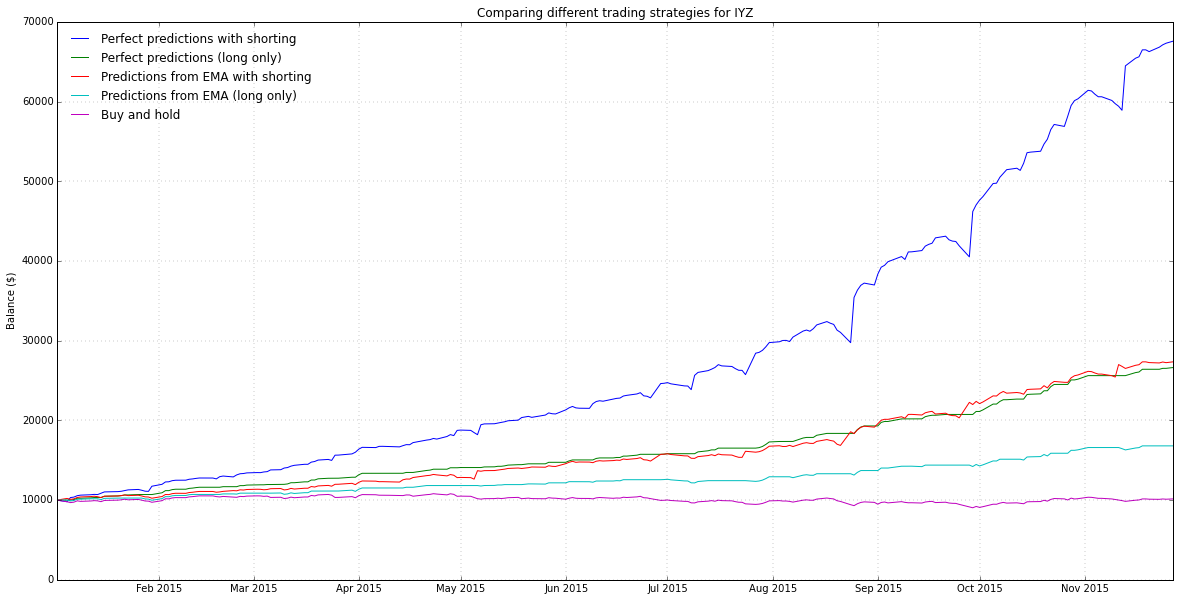

In [13]:
plt.figure(figsize=(20,10)) 
plt.title("Comparing different trading strategies for " + ticker)
plot_balance_over_time(balance_over_time_max_gain_short, "Perfect predictions with shorting")
plot_balance_over_time(balance_over_time_max_gain, "Perfect predictions (long only)")
plot_balance_over_time(balance_over_time_EMA_short, "Predictions from EMA with shorting")
plot_balance_over_time(balance_over_time_EMA, "Predictions from EMA (long only)")
plot_balance_over_time(balance_over_time_baseline, "Buy and hold")
